# Sentiment Analysis
Predict positive or negative sentiments using Naive Bayes, XGBoost and HuggingFace Transformers.

Anushka Goel (015003)


# Table of Content

* [Intro](#intro)
* [Importing packages and loading data](#imp)
* [Exploratory Data Analysis (EDA)](#eda)
* [Text Processing](#pro)
    * [1. Clean Text](#clean)
    * [2. Remove Stopwords](#stop)
    * [3. Stemming](#stem)
    * [3. Lemmatization](#lemm)
* [Feature Engineering and Selection](#fe)
* [Models](#ml)
    * [Naive Bayes](#nb)
    * [XGBoost](#xgb)
    * [HuggingFace Transformers](#tr)

### About dataset
This is a list of over 2540 consumer reviews for electronic product OnePlus Nord CE. The dataset includes basic product information, rating, review text, and more for each product.

# Scrapping of Amazon Product Reviews

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url='https://www.amazon.in/OnePlus-Nord-Charcoal-128GB-Storage/product-reviews/B09576CYNP/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber='


df = pd.DataFrame(reviewlist)
df.to_excel('OnePlus Nord CE 5G.xlsx', index=False)
print('Complete')

In [ ]:
def get_soup(url):
    r = requests.get('http://localhost:8050/render.html', params={'url': url, 'wait': 2})
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {
            'product': soup.title.text.replace('Amazon.co.uk:Customer reviews:', '').strip(),
            'title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
            'rating':  float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
            'body': item.find('span', {'data-hook': 'review-body'}).text.strip(),
            }
            reviewlist.append(review)
    except:
        pass

In [ ]:
reviewlist = []
for x in range(1,999):
    soup = get_soup(f'https://www.amazon.in/OnePlus-Nord-Charcoal-128GB-Storage/product-reviews/B09576CYNP/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber={x}')
    print(f'Getting page: {x}')
    get_reviews(soup)
    print(len(reviewlist))
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break

<a id='imp'></a>
# Importing packages and loading data

In [1]:
# required libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset 
df = pd.read_csv('C:\\Users\\HP\\Desktop\\FORE\\TERM-4\\Deep Learning & NLP\\op nord.csv')
df.head()

,reviews.username,reviews.title,reviews.rating,reviews.text
0,Amazon.in:Customer reviews: OnePlus Nord CE 5G...,Bakwas phone,1,Bakwas phone
1,Amazon.in:Customer reviews: OnePlus Nord CE 5G...,After replacement..now better,3,Few issues are resolved that are mention below...
2,Amazon.in:Customer reviews: OnePlus Nord CE 5G...,Good overall,4,The best part of the phone is it's super simpl...
3,Amazon.in:Customer reviews: OnePlus Nord CE 5G...,Worst phone in this segment,1,Phone looks good but features are 10k phoneCam...
4,Amazon.in:Customer reviews: OnePlus Nord CE 5G...,Smooth user experience,5,Performance is really good - no lags at allPer...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540 entries, 0 to 2539
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews.username  2540 non-null   object
 1   reviews.title     2540 non-null   object
 2   reviews.rating    2540 non-null   int64 
 3   reviews.text      2534 non-null   object
dtypes: int64(1), object(3)
memory usage: 79.5+ KB


<a id='eda'></a>
# Exploratory Data Analysis (EDA)


Since we are interested in sentiment analysis, we will only use `reviews.text` and `reviews.rating`

In [4]:
data = df[["reviews.text","reviews.rating"]]
data.head()

,reviews.text,reviews.rating
0,Bakwas phone,1
1,Few issues are resolved that are mention below...,3
2,The best part of the phone is it's super simpl...,4
3,Phone looks good but features are 10k phoneCam...,1
4,Performance is really good - no lags at allPer...,5


In [5]:
# drop missing values
data.dropna(inplace=True)
data.isnull().sum()

reviews.text      0
reviews.rating    0
dtype: int64

In [7]:
# distribution of rating
data['reviews.rating'].value_counts().sort_index(ascending=False)

5    627
4    437
3    359
2    271
1    840
Name: reviews.rating, dtype: int64

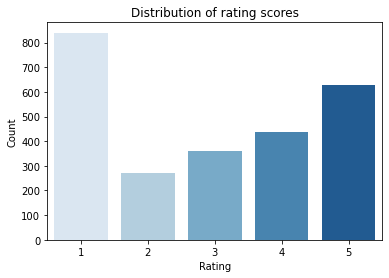

In [8]:
# distribution of rating
sns.countplot(data['reviews.rating'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [9]:
# map ratings 1, 2, 3 to 0 (NEGATIVE) and 4, 5 to 1 (POSITIVE) 
sentiment_score = {1: 0,
                   2: 0,
                   3: 0,
                   4: 1,
                   5: 1}

sentiment = {0: 'NEGATIVE',
             1: 'POSITIVE'}


# mapping
data['sentiment_score'] = data['reviews.rating'].map(sentiment_score)
data['sentiment'] = data['sentiment_score'].map(sentiment)

data.head()

,reviews.text,reviews.rating,sentiment_score,sentiment
0,Bakwas phone,1,0,NEGATIVE
1,Few issues are resolved that are mention below...,3,0,NEGATIVE
2,The best part of the phone is it's super simpl...,4,1,POSITIVE
3,Phone looks good but features are 10k phoneCam...,1,0,NEGATIVE
4,Performance is really good - no lags at allPer...,5,1,POSITIVE


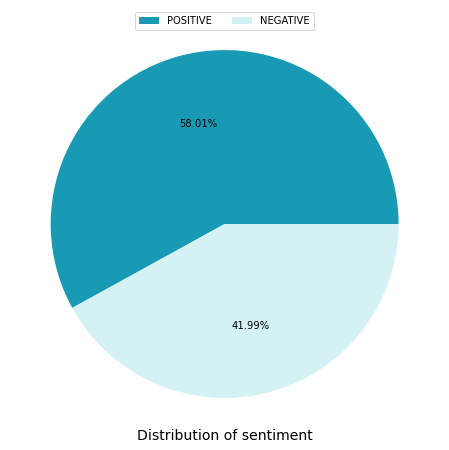

In [10]:
# distribution of sentiment
plt.figure(figsize = (8, 8))

labels = ['POSITIVE', 'NEGATIVE']
colors = ['#189AB4', '#D4F1F4']
plt.pie(data['sentiment'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

<a id='pro'></a>
## Text Processing

<a id='clean'></a>
### 1. Clean Text
We will go over some simple techniques to clean and prepare text data for modeling with machine learning.

In [18]:
def clean_text(text:str):
    """ Return cleaned text:
            - lowercase
            - remove whitespaces
            - remove HTML tags
            - replace digit with spaces
            - replace punctuations with spaces
            - remove extra spaces and tabs
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    
    text = text.lower()
    text = text.strip()
    
    text = re.sub(' \d+', ' ', text)
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    
    text = text.strip()
    
    return text

<a id='stop'></a>
### 2. Remove Stopwords
There can be some words in our sentences that occur very frequently and don't contribute too much to the overall meaning of the sentences. We usually have a list of these words and remove them from each our sentences. For example: "a", "an", "the", "this", "that", "is", "it", "to", "and" in this example.

In [19]:
def remove_stopwords(text:str):
    """ Remove stopwords from text:
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    filtered_sentence = []

    
    stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and",'oneplus','nord','ce']

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(w)
    text = " ".join(filtered_sentence)
    
    return text

<a id='stem'></a>
### 3. Stemming
Stemming is a rule-based system to convert words into their root form. It removes suffixes from words. This helps us enhace similarities (if any) between sentences. 

Example:
> "jumping", "jumped" -> "jump"
>
> "cars" -> "car"

In [20]:
def stemm_text(text:str):
    """ Stemm text:
    ------
    input: text (str)    
    output: Stemmed text (str)
    """
    text = str(text)
    # Initialize the stemmer
    snow = SnowballStemmer('english')

    stemmed_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        # Stem the word/token
        stemmed_sentence.append(snow.stem(w))
    text = " ".join(stemmed_sentence)
    
    return text

<a id='lemm'></a>
### 4. Lemmatization
If we are not satisfied with the result of stemming, we can use the Lemmatization instead. It usually requires more work, but gives better results. As mentioned in the class, lemmatization needs to know the correct word position tags such as "noun", "verb", "adjective", etc. and we will use another NLTK function to feed this information to the lemmatizer.

In [21]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [22]:
def lemmatize(text:str):
    """ lemmatize text:
    ------
    input: text (str)    
    output: lemmatized text (str)
    """
    text = str(text)
    
    # Initialize the lemmatizer
    wl = WordNetLemmatizer()

    lemmatized_sentence = []

    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    word_pos_tags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    lemmatized_text = " ".join(lemmatized_sentence)
    
    return lemmatized_text

### Apply text processing functions 

In [23]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [24]:
# clean text
data['text'] = data['reviews.text'].apply(clean_text)
# remove stopwords
data['text'] = data['text'].apply(remove_stopwords)
# lemmatize
data['text'] = data['text'].apply(lemmatize)

In [25]:
# export cleaned data to csv
data.to_csv('cleaned_data.csv', index=False)

In [26]:
data = pd.read_csv('cleaned_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviews.text     2534 non-null   object
 1   reviews.rating   2534 non-null   int64 
 2   sentiment_score  2534 non-null   int64 
 3   sentiment        2534 non-null   object
 4   text             2534 non-null   object
dtypes: int64(2), object(3)
memory usage: 99.1+ KB


In [27]:
data[data['text'].isnull()]

,reviews.text,reviews.rating,sentiment_score,sentiment,text


### Most used words

#### All Reviews

In [12]:
# get all used words 
all_words = pd.Series(' '.join(data['reviews.text']).split())

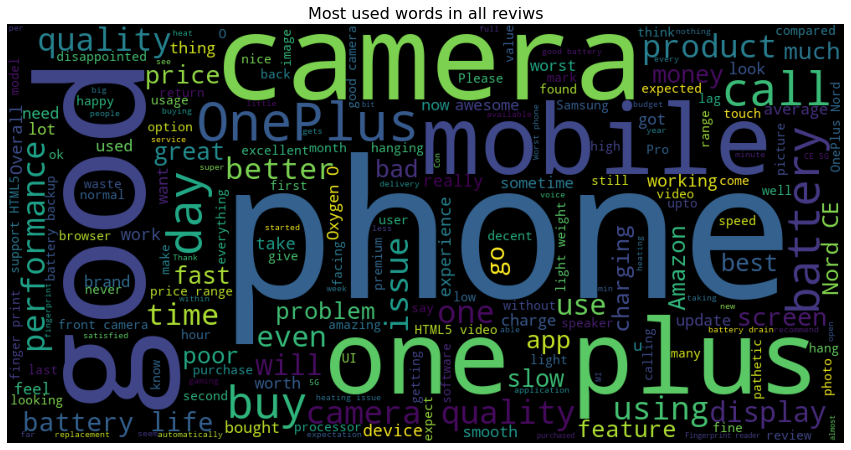

In [13]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(all_words))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in all reviws", size=16)

plt.axis("off")
plt.show()

#### Positive Reviews

In [14]:
# get words used positive reivews 
positiveWords = pd.Series(' '.join(data[data['sentiment']=='POSITIVE']['reviews.text']).split())

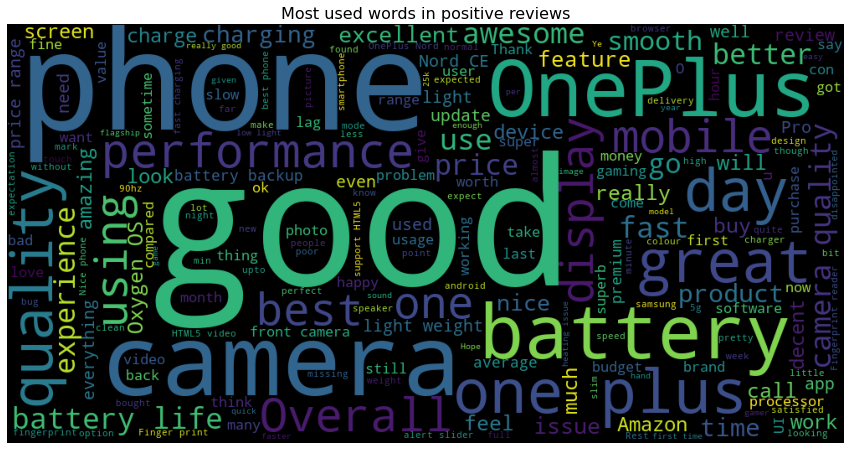

In [15]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positiveWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in positive reviews", size=16)

plt.axis("off")
plt.show()

#### Negative Reviews

In [16]:
# get words used negative reivews 
negativeWords = pd.Series(' '.join(data[data['sentiment']=='NEGATIVE']['reviews.text']).split())

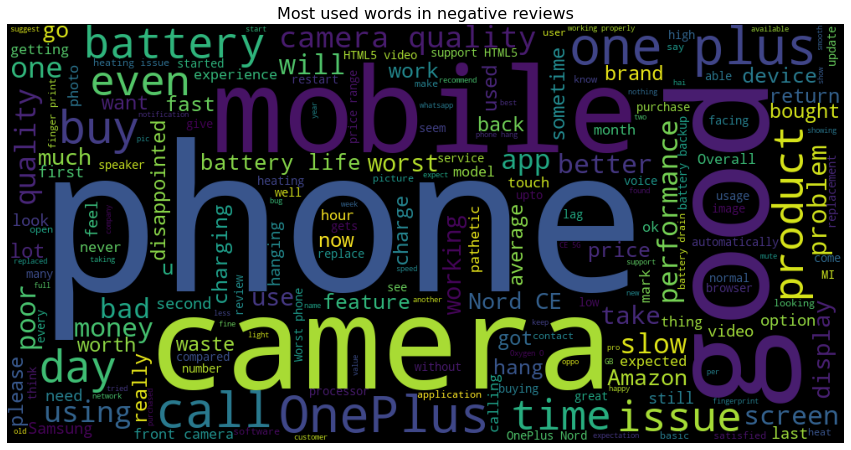

In [17]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negativeWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size=16)

plt.axis("off")
plt.show()

<a id='fe'></a>
# Feature Engineering and Selection

### Create TF-IDF

In [29]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer.fit(data['text'])
features = vectorizer.transform(data['text'])

features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
tf_idf = pd.DataFrame(features.toarray(), columns=vectorizer.get_feature_names())
# tf_idf.drop('50', axis=1, inplace=True)
tf_idf.head()

,10,5mm,able,about,above,accord,actually,add,affordable,after,...,would,write,wrong,year,yes,yet,you,your,youtube,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154472,0.0


### Splitting Dataset into Train and Test Set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, data['sentiment_score'], test_size=0.2, random_state=42)

print (f'Train set shape\t:{X_train.shape}\nTest set shape\t:{X_test.shape}')

Train set shape	:(2027, 700)
Test set shape	:(507, 700)


<a id='ml'></a>
# Models

In [38]:
def modeling(Model, Xtrain = X_train, Xtest = X_test):
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    print(classification_report(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)
    plt.figure(figsize = (8,8))

    sns.heatmap(confusion_matrix, annot=True,annot_kws={"fontsize":12}, fmt='.2f', cmap='Blues').set_title('Confusion Matrix') 

<a id='nb'></a>
### Naiave Bayes

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       298
           1       0.76      0.87      0.81       209

    accuracy                           0.83       507
   macro avg       0.83      0.84      0.83       507
weighted avg       0.84      0.83      0.84       507

AUC  0.8397691146719759


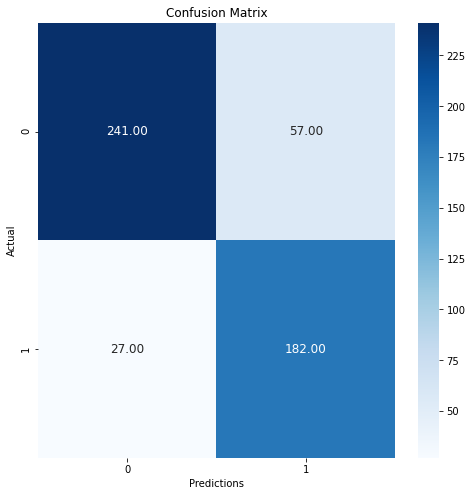

In [39]:
modeling(MultinomialNB())

<a id='xbg'></a>
### XGBoost

[00:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       298
           1       0.75      0.83      0.78       209

    accuracy                           0.81       507
   macro avg       0.81      0.81      0.81       507
weighted avg       0.82      0.81      0.81       507

AUC  0.8148823094955204


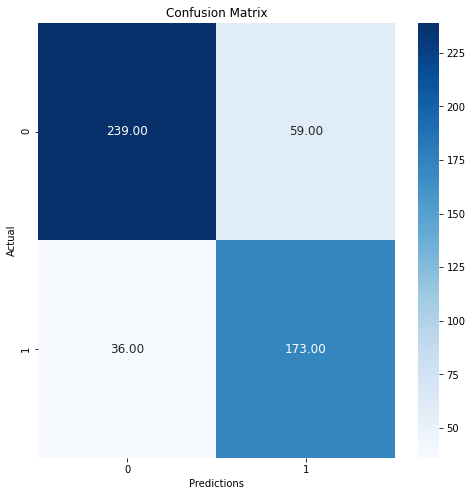

In [40]:
modeling(XGBClassifier());

<a id='tr'></a>
### HuggingFace Transformer

Transformers library by Huggingface. We will be using pretrained transformers rather than fine-tuning our own, so a low setup cost is needed.

In [41]:
# Build sentiment analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [42]:
# test
sentiment_analyzer(['Good product', 'Bad custemer service'])

[{'label': 'POSITIVE', 'score': 0.9998588562011719},
 {'label': 'NEGATIVE', 'score': 0.999789297580719}]

In [43]:
def transformer_check(n=1000):
    """ Return Dataframe of reviews sentimental prediction and actual sentimental"""
    res_list = []
    for _ in range(n):
        res_dict = {}
        i = random.choice(range(len(data)))
        text_ = data['text'].iloc[i]
        sen_act = data['sentiment'].iloc[i]
        sen_pred = sentiment_analyzer(text_)[0]['label']
        res_dict['review'] = text_
        res_dict['sen_act'] = sen_act
        res_dict['sen_pred'] = sen_pred
        res_dict['match'] = sen_act == sen_pred
        
        res_list.append(res_dict)
        
    return pd.DataFrame(res_list)

In [44]:
results = transformer_check()

In [45]:
results.sample(10)x3a2

,review,sen_act,sen_pred,match
557,battery backuphigh user 4 of daymoderate user ...,POSITIVE,NEGATIVE,False
679,first of all phone have degrade quality base o...,NEGATIVE,NEGATIVE,True
926,although phone carry tag of one plus but perfo...,POSITIVE,NEGATIVE,False
286,camera have issue not sure if s common across ...,NEGATIVE,NEGATIVE,True
363,worst phone ever 1 no wrap charge w charge not...,NEGATIVE,NEGATIVE,True
826,mobile have bluetooth problem game app win t r...,NEGATIVE,NEGATIVE,True
717,finger print reader average back button opposi...,POSITIVE,POSITIVE,True
788,pro processor light weight back camera display...,NEGATIVE,NEGATIVE,True
901,worst mobile ever not worth of k k mobile it b...,NEGATIVE,NEGATIVE,True
388,hi i want raise complaint my mobile get struck...,NEGATIVE,NEGATIVE,True
